# Overview

This notebook will import a series of backend functions to perform a reconstruction interactively.

In [1]:
%matplotlib inline

In [2]:
import logging
import numpy as np
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
import imars3d

## Load the data

In [4]:
from imars3d.backend.io.data import load_data

olefile module not found


> the notebook is generate on my laptop, so I used my locally cached raw data to avoid downloading them from server.

In [5]:
%%time

ct, ob, dc, rot_angles = load_data(
    ct_dir="/home/8cz/tmp/HFIR/CG1D/IPTS-25777/raw/ct_scans/iron_man",  # replace with /HFIR/CG1D/IPTS-25777/raw/ct_scans/iron_man
    ob_dir="/home/8cz/tmp/HFIR/CG1D/IPTS-25777/raw/ob",  # replace with /HFIR/CG1D/IPTS-25777/raw/ob/Oct29_2019/
    dc_dir="/home/8cz/tmp/HFIR/CG1D/IPTS-25777/raw/df",  # replace with /HFIR/CG1D/IPTS-25777/raw/df/Oct29_2019/
    ct_fnmatch="*.tiff",
    ob_fnmatch="*.tiff",
    dc_fnmatch="*.tiff",
)

ct:   0%|          | 0/622 [00:00<?, ?it/s]

ob:   0%|          | 0/7 [00:00<?, ?it/s]

dc:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:imars3d.backend.io.data: Using rotation angles from filenames.


CPU times: user 7.78 s, sys: 5.28 s, total: 13.1 s
Wall time: 13.3 s


## Preprocess data

### step 0: crop image

For smaller machines with limited ram, cropping early is very important, espeically since tomopy will convert everything to float during processing regardless whether it is necessary or not.

In [6]:
from imars3d.backend.morph.crop import crop

In [7]:
crop_limit = (552, 1494, 771, 1296)  # left, right, top, bottom

In [8]:
%%time

ct = crop(arrays=ct, crop_limit=crop_limit)

INFO:imars3d.backend.morph.crop: Executing Filter: Crop
INFO:imars3d.backend.morph.crop: FINISHED Executing Filter: Crop


CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 1.5 ms


In [9]:
%%time

ob = crop(arrays=ob, crop_limit=crop_limit)

INFO:imars3d.backend.morph.crop: Executing Filter: Crop
INFO:imars3d.backend.morph.crop: FINISHED Executing Filter: Crop


CPU times: user 2.09 ms, sys: 0 ns, total: 2.09 ms
Wall time: 1.5 ms


In [10]:
%%time

dc = crop(arrays=dc, crop_limit=crop_limit)

INFO:imars3d.backend.morph.crop: Executing Filter: Crop
INFO:imars3d.backend.morph.crop: FINISHED Executing Filter: Crop


CPU times: user 2.03 ms, sys: 872 µs, total: 2.91 ms
Wall time: 1.82 ms


### step 1: gamma filtering radiographs

In [11]:
from imars3d.backend.corrections.gamma_filter import gamma_filter

In [12]:
%%time

# use default input arguments
# selective median filter is expensive for small machine, we can skip it for tests by setting selective_median_filter=False if necessary.
ct = gamma_filter(arrays=ct)

INFO:imars3d.backend.corrections.gamma_filter: Executing Filter: Gamma Filter
INFO:imars3d.backend.corrections.gamma_filter: FINISHED Executing Filter: Gamma Filter


CPU times: user 5min 20s, sys: 23.9 s, total: 5min 44s
Wall time: 35.3 s


### step 2: perform normalization

In [13]:
from imars3d.backend.preparation.normalization import normalization

In [14]:
%%time

ct = normalization(arrays=ct, flats=ob, darks=dc)

INFO:imars3d.backend.preparation.normalization: Executing Filter: Normalization
INFO:imars3d.backend.preparation.normalization: FINISHED Executing Filter: Normalization


CPU times: user 3.47 s, sys: 1.45 s, total: 4.93 s
Wall time: 614 ms


[optional] we have no need for `ob` and `dc` from this point on

In [15]:
del ob
del dc

### step 3: supporess noise

Noise reduction can help remove streaky type artifacts in the final reconstruction, but the bilateral method (default) might take some time to finish.
If the overall runtime for integration test is too long, we can skip this step as we don't really care about the niceness/cleaness of the final reconstruction results during integration test.

In [16]:
from imars3d.backend.corrections.denoise import denoise

In [17]:
%%time

# the default argument should be good for most cases
ct = denoise(arrays=ct)

INFO:imars3d.backend.corrections.denoise: Executing Filter: Denoise Filter
INFO:imars3d.backend.corrections.denoise: Executing Filter: Denoise Filter with bilateral filter


denoise_by_bilateral:   0%|          | 0/622 [00:00<?, ?it/s]

INFO:imars3d.backend.corrections.denoise: denoise completed via bilateral filter


CPU times: user 3.28 s, sys: 2.53 s, total: 5.8 s
Wall time: 10min 22s


This takes about 6 min on my laptop (i9, 16 cores, 32G ram), so it might take forever to run on a much weaker runner.

### step 4: ring artifact removal

This step is definitely optional, and we can cut it out to safe time if necessary.

In [18]:
from imars3d.backend.corrections.ring_removal import remove_ring_artifact

In [19]:
%%time

ct = remove_ring_artifact(arrays=ct)

INFO:imars3d.backend.corrections.ring_removal: Executing Filter: Remove Ring Artifact


Removing ring artifact:   0%|          | 0/525 [00:00<?, ?it/s]

INFO:imars3d.backend.corrections.ring_removal: FINISHED Executing Filter: Remove Ring Artifact


CPU times: user 4.28 s, sys: 2.34 s, total: 6.62 s
Wall time: 6.06 s


### step 5: find rotation center

make sure `atol_deg` is close to the rotation step resolution so that the 180 deg pairs can be accurately found.

In [20]:
from imars3d.backend.diagnostics.rotation import find_rotation_center

In [21]:
%%time

rot_cnt = find_rotation_center(arrays=ct, angles=rot_angles, in_degrees=True, atol_deg=0.5)

INFO:imars3d.backend.diagnostics.rotation: Executing Filter: Find Rotation Center


Finding rotation center:   0%|          | 0/623 [00:00<?, ?it/s]

INFO:imars3d.backend.diagnostics.rotation: FINISHED Executing Filter: Find Rotation Center


CPU times: user 2.41 s, sys: 1.64 s, total: 4.06 s
Wall time: 48.7 s


In [22]:
print(rot_cnt)

535.5


### step 6: perform reconstruction

In [23]:
from imars3d.backend.reconstruction import recon

IMPORTANT!!!

tomopy expects rotation angles in radians, but neutron imaging team store their data in degrees, so we will need to use numpy to perform a quick conversion.

In [24]:
%%time

rot_ang_rad = np.radians(rot_angles)

CPU times: user 28 µs, sys: 4 µs, total: 32 µs
Wall time: 34.8 µs


In [25]:
%%time

rst = recon(arrays=ct, theta=rot_ang_rad, center=rot_cnt)

INFO:imars3d.backend.reconstruction: Executing Filter: Reconstruction
INFO:imars3d.backend.reconstruction: FINISHED Executing Filter: Reconstruction: hann


CPU times: user 37.7 s, sys: 1.42 s, total: 39.1 s
Wall time: 3.61 s


Technically the integration test ends here.
The rest is just showing the reconstruction results.

In [26]:
rst.shape

(525, 942, 942)

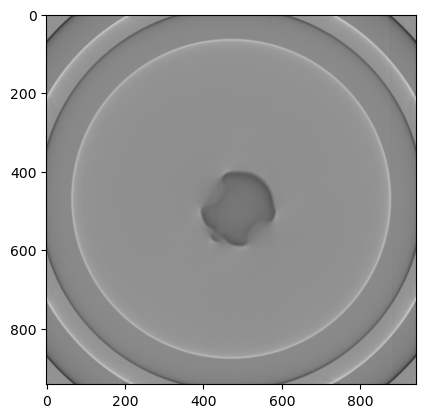

In [27]:
plt.imshow(rst[300], cmap="gray")

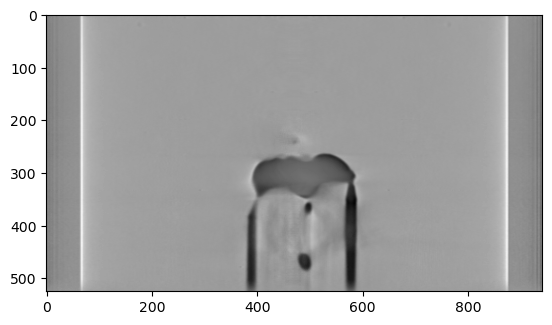

In [28]:
plt.imshow(rst[:, 500, :], cmap="gray")

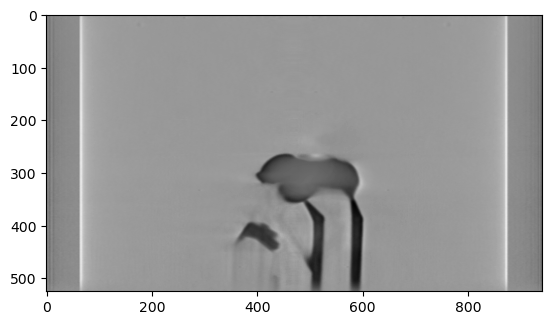

In [29]:
plt.imshow(rst[:, :, 500], cmap="gray")